## Historical Menu Project

* This project uses historical menus from the New York Public Library's "What's on the Menu?" database. It can be downloaded in spreadsheet form or accessed through an API at <http://menus.nypl.org/data>

* Digital scans of the menus are available (although not currently working ...).

* The data include bibliographic information about the menus (including date and location, entered by the Library), and info on individual dishes (including price and x/y position on the menu), transcribed by the public. Eventually, I'd like to use these data to demonstrate what the food scene looked like at particular times and locations, show how dishes have changed in relative price over time, and see if we can predict food trends.

Let's see what I've done so far ...

#### Import necessary modules

In [2]:
import datetime as dt
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Read in the files and convert to Pandas dataframes

In [92]:
dishes_filename = '/Users/amyshapiro/projects/nyc_menu_project/Dish.csv'
menu_item_filename = '/Users/amyshapiro/projects/nyc_menu_project/MenuItem.csv'
menu_filename = '/Users/amyshapiro/projects/nyc_menu_project/Menu.csv'
menu_page_filename = '/Users/amyshapiro/projects/nyc_menu_project/MenuPage.csv'

dishes_df = pd.read_csv(dishes_filename)
menu_item_df = pd.read_csv(menu_item_filename)
menu_df = pd.read_csv(menu_filename)
menu_page_df = pd.read_csv(menu_page_filename)

### Take a closer look at each dataframe

#### The Dishes Dataframe

   * provides information on each unique menu dish
   * where we find the name of each dish 

In [93]:
dishes_df.head(10)

,id,name,description,menus_appeared,times_appeared,first_appeared,last_appeared,lowest_price,highest_price
0,1,Consomme printaniere royal,NaN,8,9,1897,1927,0.20,0.4
1,2,Chicken gumbo,NaN,110,116,1895,1960,0.10,0.8
2,3,Tomato aux croutons,NaN,13,13,1893,1917,0.25,0.4
3,4,Onion au gratin,NaN,41,41,1900,1971,0.25,1.0
4,5,St. Emilion,NaN,66,68,1881,1981,0.00,18.0
5,7,Radishes,NaN,3265,3349,1854,2928,0.00,25.0
6,8,Chicken soup with rice,NaN,48,49,1897,1961,0.10,0.6
7,9,Clam broth (cup),NaN,15,17,1899,1962,0.15,0.4
8,10,"Cream of new asparagus, croutons",NaN,2,2,1900,1900,0.00,0.0
9,11,Clear green turtle,NaN,157,157,1893,1937,0.25,60.0


In [94]:
dishes_df.describe()

,id,description,menus_appeared,times_appeared,first_appeared,last_appeared,lowest_price,highest_price
count,421478.000000,0.0,421478.000000,421478.000000,421478.000000,421478.000000,392378.000000,392378.000000
mean,263317.148390,NaN,3.069014,3.159973,1683.143215,1686.945632,0.969985,1.611719
std,149878.660876,NaN,27.890514,30.040351,642.892662,643.471510,6.730624,12.726787
min,1.000000,NaN,0.000000,-6.000000,0.000000,0.000000,0.000000,0.000000
25%,131791.250000,NaN,1.000000,1.000000,1900.000000,1900.000000,0.000000,0.000000
50%,268377.500000,NaN,1.000000,1.000000,1914.000000,1917.000000,0.000000,0.000000
75%,395608.750000,NaN,1.000000,1.000000,1949.000000,1955.000000,0.400000,0.600000
max,513758.000000,NaN,7741.000000,8486.000000,2928.000000,2928.000000,1035.000000,3050.000000


These data are a bit messy, likely because they're entered by the public :) 

Some dishes apparently don't have:

* first or last appearance dates
* low or high prices
* never appeared on a menu
* or appeared negative times! 

Luckily we can calculate most of these values ourselves from other information provided.
One thing we can quickly find here though: 

#### What are the most common dishes of all-time?

In [95]:
dishes_df.sort_values('times_appeared', ascending=False).head(15)

,id,name,description,menus_appeared,times_appeared,first_appeared,last_appeared,lowest_price,highest_price
88,96,Coffee,NaN,7741,8486,1,2928,0.0,30.0
89,97,Tea,NaN,4158,4769,1858,2012,0.0,25.0
13,15,Celery,NaN,4247,4691,1,2928,0.0,50.0
978,1177,Olives,NaN,4321,4554,1858,1980,0.0,35.0
5,7,Radishes,NaN,3265,3349,1854,2928,0.0,25.0
76,83,Mashed potatoes,NaN,2586,2676,1852,2012,0.0,15.0
90,98,Milk,NaN,1896,2294,1890,2012,0.0,45.0
203,219,Boiled potatoes,NaN,2080,2135,1858,1974,0.0,20.0
104,112,Fruit,NaN,1921,2008,1854,2928,0.0,40.0
201,217,Chicken salad,NaN,1819,1889,1858,1987,0.0,100.0


These dishes can be characterized as:

1. simple dishes
2. names are only a few words long (most are single words)
3. are on menus before 1900 and up to today (earliest last appearance is 1974). 

Dishes are case, spelling, and punctuation dependent. There are probably lots of other dishes that could fall under the category of 'Coffee', for example, but only items that exactly match the string 'Coffee' are included in this dish category. We could aggregate similar dishes, such as 'Coffee' and 'coffee', to take a broader look at each type of dish. We'll do this later.

#### Menu Item Dataframe

 * Provides info on each specific dish listed on each menu, as well as when the info was entered. 
 * Contains info on where, in x/y position, the item appears on the menu, and the all-important price.

In [96]:
menu_item_df.head()

,id,menu_page_id,price,high_price,dish_id,created_at,updated_at,xpos,ypos
0,1,1389,0.4,NaN,1.0,2011-03-28 15:00:44 UTC,2011-04-19 04:33:15 UTC,0.111429,0.254735
1,2,1389,0.6,NaN,2.0,2011-03-28 15:01:13 UTC,2011-04-19 15:00:54 UTC,0.438571,0.254735
2,3,1389,0.4,NaN,3.0,2011-03-28 15:01:40 UTC,2011-04-19 19:10:05 UTC,0.140000,0.261922
3,4,1389,0.5,NaN,4.0,2011-03-28 15:01:51 UTC,2011-04-19 19:07:01 UTC,0.377143,0.262720
4,5,3079,0.5,1.0,5.0,2011-03-28 15:21:26 UTC,2011-04-13 15:25:27 UTC,0.105714,0.313178


#### Menu Dataframe

* Contains bibliographic info on each menu, including the place the menu comes from, the date, and the currency.
* However, many columns contain many NaNs.

In [97]:
menu_df.head()

,id,name,sponsor,event,venue,place,physical_description,occasion,notes,call_number,keywords,language,date,location,location_type,currency,currency_symbol,status,page_count,dish_count
0,12463,NaN,HOTEL EASTMAN,BREAKFAST,COMMERCIAL,"HOT SPRINGS, AR",CARD; 4.75X7.5;,EASTER;,NaN,1900-2822,NaN,NaN,1900-04-15,Hotel Eastman,NaN,NaN,NaN,complete,2,67
1,12464,NaN,REPUBLICAN HOUSE,[DINNER],COMMERCIAL,"MILWAUKEE, [WI];",CARD; ILLUS; COL; 7.0X9.0;,EASTER;,WEDGEWOOD BLUE CARD; WHITE EMBOSSED GREEK KEY ...,1900-2825,NaN,NaN,1900-04-15,Republican House,NaN,NaN,NaN,complete,2,34
2,12465,NaN,NORDDEUTSCHER LLOYD BREMEN,FRUHSTUCK/BREAKFAST;,COMMERCIAL,DAMPFER KAISER WILHELM DER GROSSE;,CARD; ILLU; COL; 5.5X8.0;,NaN,"MENU IN GERMAN AND ENGLISH; ILLUS, STEAMSHIP A...",1900-2827,NaN,NaN,1900-04-16,Norddeutscher Lloyd Bremen,NaN,NaN,NaN,complete,2,84
3,12466,NaN,NORDDEUTSCHER LLOYD BREMEN,LUNCH;,COMMERCIAL,DAMPFER KAISER WILHELM DER GROSSE;,CARD; ILLU; COL; 5.5X8.0;,NaN,"MENU IN GERMAN AND ENGLISH; ILLUS, HARBOR SCEN...",1900-2828,NaN,NaN,1900-04-16,Norddeutscher Lloyd Bremen,NaN,NaN,NaN,complete,2,63
4,12467,NaN,NORDDEUTSCHER LLOYD BREMEN,DINNER;,COMMERCIAL,DAMPFER KAISER WILHELM DER GROSSE;,FOLDER; ILLU; COL; 5.5X7.5;,NaN,"MENU IN GERMAN AND ENGLISH; ILLUS, HARBOR SCEN...",1900-2829,NaN,NaN,1900-04-16,Norddeutscher Lloyd Bremen,NaN,NaN,NaN,complete,4,33


One issue I encountered here is that not all the menus have a date. We can see this by looking at the size of the menu database and the 'date' column. 

In [98]:
print len(menu_df)
print menu_df['date'].count()

17545
16959


We could drop all menus without a date, but there are actually a few tricks we can use to keep some of these menus in our dataset. The menus have a library call number, which starts with the year of 'publication' of the menu (unless it is a special collection; unfortunately those will be dropped if their date is missing). We can use this number as a 'year' variable.

First, create a new variable that takes the first 4 digits of the library call number (filling with 0 if this is not numeric).

In [99]:
menu_df['year_from_call_number'] = menu_df['call_number'].str[0:4].fillna(0)
menu_df['year_from_call_number']=pd.to_numeric(menu_df['year_from_call_number'], errors='coerce').fillna(0)

Also, 'date' is a string, so let's change that to a datetime format so we can easily extract the year (and month/day). If that date is not in the right format, fill with 0.

In [100]:
menu_df['date_time'] = pd.to_datetime(menu_df['date'], errors='coerce')
menu_df['year']=menu_df['date_time'].dt.year.fillna(0)
print len(menu_df.loc[menu_df['year'] != 0])

16954


This gives about the same size as above (accounting for some 0s).

Now let's add in the year we got from the call number if the year == 0

In [101]:
menu_df.loc[menu_df['year'] == 0, 'year'] = menu_df['year_from_call_number']

In [102]:
menu_df=menu_df.loc[menu_df['year'] > 0]
menu_df['year'].describe()

count    17006.000000
mean      1916.940198
std         24.126551
min       1851.000000
25%       1900.000000
50%       1907.000000
75%       1928.000000
max       2015.000000
Name: year, dtype: float64

Well, we got about 50 menus from that. But we'll get many more dishes! The range of years looks good. Let's visualize this to see how the menus are distributed over time.

[(0, 500)]

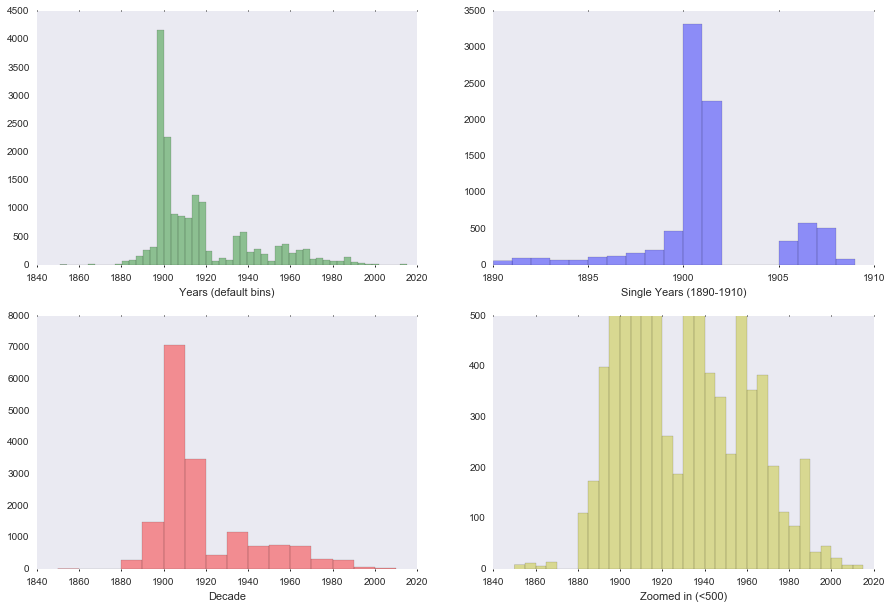

In [103]:
#set seaborn plot style and palette
sns.set_style('dark', {'xtick.major.size': 1.5})
sns.set_palette('deep')

f, axes = plt.subplots(2,2, figsize=(15, 10), sharex=False)

#Plot the number of menus by year using default bins
y= menu_df['year']
sns.distplot(y, hist=True, kde= False, color = 'g', axlabel= 'Years (default bins)', ax=axes[0,0])

#Plot the number of menus for each year
sns.distplot(y, hist = True, kde = False, color = 'b', axlabel= 'Single Years (1890-1910)',
             ax=axes[0,1], bins=range(1890,1910,1))

#Plot the number of menus by decade
sns.distplot(y, kde=False, bins=range(1850,2020,10), color = 'r', axlabel='Decade', ax=axes[1,0])

#Plot the number of menus by year using bins of 5 years, but zoom in to < 500
sns.distplot(y, hist = True, kde = False, bins=range(1850,2020,5), color = 'y', axlabel= 'Zoomed in (<500)',
             ax=axes[1,1]).set(ylim=[0, 500])

There are clearly some times (1900-1920) with lots of menus, others with few. But between 1880 and 1990 we have about 100 menus per each 5 year span. 

There are also A LOT of menus from 1900-1901. Did I introduce an error by adding the call numbers, or are there actually just a ton of menus from these years? Let's check.

In [104]:
print '1900:', len(menu_df.loc[menu_df['date_time'].dt.year == 1900])
print '1901:', len(menu_df.loc[menu_df['date_time'].dt.year == 1901])

1900: 3326
1901: 2263


Looks about right from the histogram; think we're ok!

#### Menu Page Dataframe
* Contains info on the menu page, such as size, and order in the menu (first page, third page, etc.)
* Will only be used here as a way to link the menu items and menu dataframes

In [105]:
menu_page_df.head()

,id,menu_id,page_number,image_id,full_height,full_width,uuid
0,119,12460,1.0,1603595,7230.0,5428.0,510d47e4-2955-a3d9-e040-e00a18064a99
1,120,12460,2.0,1603596,5428.0,7230.0,510d47e4-2956-a3d9-e040-e00a18064a99
2,121,12460,3.0,1603597,7230.0,5428.0,510d47e4-2957-a3d9-e040-e00a18064a99
3,122,12460,4.0,1603598,7230.0,5428.0,510d47e4-2958-a3d9-e040-e00a18064a99
4,123,12461,1.0,1603591,7230.0,5428.0,510d47e4-2959-a3d9-e040-e00a18064a99


### Joining Dataframes

To properly look at the dish prices and dates, we need to join our dataframes. 

First, let's rename some ID columns so we can join the dataframes without too much confusion.

In [106]:
menu_item_df = menu_item_df.rename(columns={'id': 'menu_item_id'})
menu_page_df = menu_page_df.rename(columns={'id': 'menu_page_id'})
dishes_df = dishes_df.rename(columns={'id': 'dish_id'})
menu_df = menu_df.rename(columns={'id': 'menu_id', 'name': 'menu_name'})


Merge the Dishes dataframe and the Menu Item dataframe. 
But only keep the IDs, names, and prices.

In [107]:
individual_dishes_df = pd.merge(dishes_df[['dish_id', 'name']],
                                menu_item_df[['menu_item_id', 'menu_page_id', 'price', 'dish_id']],
                                how='inner', on='dish_id', sort=False, copy=True, indicator=False)

Gotta check that this worked OK!

In [108]:
individual_dishes_df.head()
len(individual_dishes_df)

1331985

Also merge our Menu and Menu Pages dataframes, keeping desired columns.

In [109]:
menu_df_to_keep = ['menu_id', 'currency', 'year']
menu_pages_to_keep = ['menu_page_id', 'menu_id']

menu_info = pd.merge(menu_df[menu_df_to_keep], menu_page_df[menu_pages_to_keep], how='inner', on='menu_id', sort=False,
                    copy=True, indicator=False)

In [110]:
menu_info.head()

,menu_id,currency,year,menu_page_id
0,12463,NaN,1900.0,129
1,12463,NaN,1900.0,130
2,12464,NaN,1900.0,131
3,12464,NaN,1900.0,132
4,12465,NaN,1900.0,133


Now the exciting part: combine all our dataframes to give us one that contains:
* all the menu items
* the names of the dishes
* their prices
* the year they appeared

Also reindex the dataframe so that the menu_item_id is the index (this is the unique ID for each menu item)

In [111]:
#Merge individual_dishes and menu_info on menu_page_id
menu_dishes_df = pd.merge(individual_dishes_df, menu_info, how='inner', on='menu_page_id', 
                          sort=False, copy=True, indicator=False)

# Re-index the df to have the menu_item_id as the index
menu_dishes_df = menu_dishes_df.set_index('menu_item_id')

In [112]:
menu_dishes_df.head()

,dish_id,name,menu_page_id,price,menu_id,currency,year
menu_item_id,,,,,,,
1,1,Consomme printaniere royal,1389,0.4,12882,Dollars,1900.0
2,2,Chicken gumbo,1389,0.6,12882,Dollars,1900.0
3,3,Tomato aux croutons,1389,0.4,12882,Dollars,1900.0
4,4,Onion au gratin,1389,0.5,12882,Dollars,1900.0
6,7,Radishes,1389,0.1,12882,Dollars,1900.0


In [113]:
print len(menu_dishes_df)

1275366


### Evaluating Prices
Some dishes don't have prices, prices are not all in dollars, and some don't have any currency entered. 

In [114]:
menu_dishes_df['currency'].describe()

count      917715
unique         39
top       Dollars
freq       845203
Name: currency, dtype: object

Create a variable that is the price if in dollars, price/100 if in cents, otherwise 0, then filter only dishes that have a non-zero price.

In [115]:
menu_dishes_df['price_in_dollars']=np.zeros(len(menu_dishes_df))
menu_dishes_df.loc[menu_dishes_df['currency'] == 'Dollars', 'price_in_dollars'] = menu_dishes_df['price']
menu_dishes_df.loc[menu_dishes_df['currency'] == 'Cents', 'price_in_dollars'] = menu_dishes_df['price']/100.
menu_dishes_df=menu_dishes_df.loc[menu_dishes_df['price_in_dollars'] > 0]

In [116]:
print len(menu_dishes_df)

780028


We now have about 780,000 data points (compared to about 1.25 million from all menu items). How are these distributed across time?

[(0, 4000)]


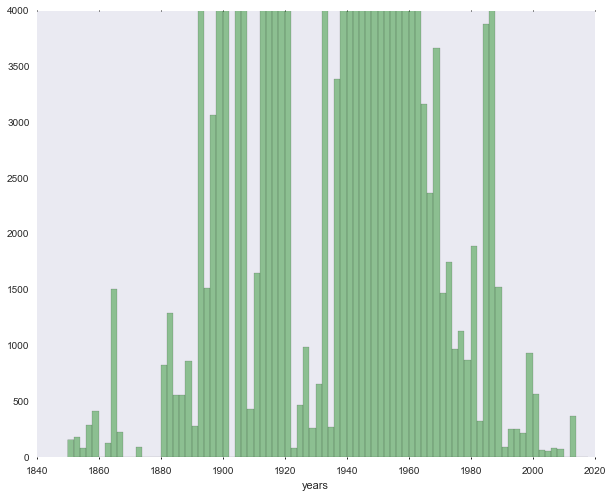

In [117]:
y= menu_dishes_df['year']
sns.mpl.rc("figure", figsize=(10, 8))

# Make a histogram that plots the frequency of individual dishes with $ prices by decade
print sns.distplot(y, hist=True, kde= False, color = 'g', bins =range(1850,2020,2), axlabel= 'years').set(ylim=(0,4000))

Somewhat similar to our menus distribution, although there are more that are between 1910-1920. 

Now let's look closer at out prices

In [118]:
menu_dishes_df['price_in_dollars'].describe()

count    780028.000000
mean          1.050150
std           6.703536
min           0.000500
25%           0.250000
50%           0.400000
75%           0.750000
max        3050.000000
Name: price_in_dollars, dtype: float64

The 75th percentile is only 75 cents! This makes sense since most dishes are from 1900-1920, when prices were very low. But, looks like there are some problems ... there are some expensive dishes (outliers) and some that cost less than 1 cent. These could be mistakes entered by humans, or issues when we converted cents to dollars. We could check these on the actual menus, but first let's see these visually.

[(0, 500), (1840, 2020)]

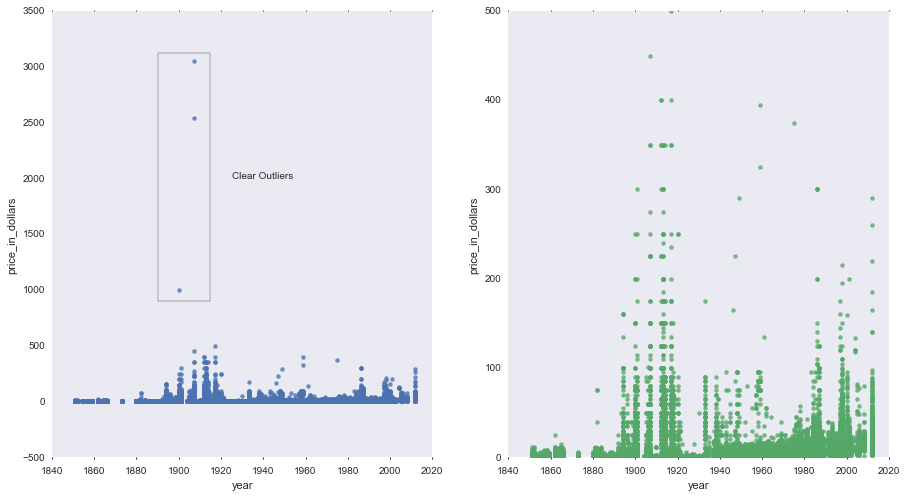

In [119]:
x= menu_dishes_df['year']
y= menu_dishes_df['price_in_dollars']
f, axes = plt.subplots(1,2, figsize = (15,8), sharex=False)
#Scatter plot of the price of each dish per year
sns.regplot(x, y, fit_reg=False, ax = axes[0]).set(xlim=(1840,2020))
axes[0].annotate('Clear Outliers', xy = (1925, 2000), xytext=(1925, 2000))
from matplotlib.patches import Rectangle
axes[0].add_patch(Rectangle((1890, 900), 25, 2220, fill=False))

# Check out everything below 500$
sns.regplot(x, y, fit_reg=False, ax = axes[1]).set(xlim=(1840,2020), ylim = (0,500))

There are some clear outliers in the left graph, and some potentials in the right graph. Let's take a closer look at some of these.

In [120]:
menu_dishes_df.sort_values('price_in_dollars', ascending=False).head(15)

,dish_id,name,menu_page_id,price,menu_id,currency,year,price_in_dollars
menu_item_id,,,,,,,,
502578,40288,Cream cheese with bar-le-duc jelly,35908,3050.0,24081,Dollars,1907.0,3050.0
502531,66,Grape fruit,35908,2540.0,24081,Dollars,1907.0,2540.0
7425,1212,"Coffee, Pot",791,1000.0,12665,Dollars,1900.0,1000.0
1084103,383432,English Pheasant,68215,500.0,32892,Dollars,1917.0,500.0
465971,9698,Canvasback Duck,28913,450.0,22214,Dollars,1907.0,450.0
1313406,473365,Special raised Squab Turkey,73674,400.0,34550,Dollars,1912.0,400.0
1312239,473190,special raised squab Turkey,73696,400.0,34562,Dollars,1912.0,400.0
1084102,1761,Mallard Duck,68215,400.0,32892,Dollars,1917.0,400.0
543627,182854,Imported Danish Ham,48949,395.0,27376,Dollars,1959.0,395.0


Well, pretty sure no one would pay 1,000 dollars for a pot of coffee, even in SF! Let's remove these three right away. Also let's make sure there are no prices under 1 cent

In [123]:
menu_dishes_df = menu_dishes_df.drop([502578, 502531, 7425])
menu_dishes_df = menu_dishes_df.loc[menu_dishes_df['price_in_dollars'] >= 0.01]

As for the rest, even during WWI, English Pheasant was not 500 dollars! Most of these are probably human error on entry or the wrong currency (Cents instead of Dollars). We could look at each of these individually, or we could say that we're only interested in dishes that are within a certain range from the mean (or better, median) price for that year. The second option will decrease our dataset more, but it will be much quicker, will remove these outliers, and will standardize our prices. 

One way to standardize is to use a Zscore. This is standardized based on the mean and standard deviation:
  * (price-mean) / std  

But, we want to do this by the mean/std for each year, since the prices increase drastically over time. However, some years don't have any menus (NaNs) and will give us some errors. Let's use the mean and std for each  **decade**.

To get the mean/std price for each decade, we first need to make a decade variable

In [124]:
menu_dishes_df['decade'] = (menu_dishes_df['year']//10)*10

Make a mean price and price std for each decade

In [125]:
dec_price = pd.DataFrame(menu_dishes_df['price_in_dollars'].groupby(menu_dishes_df['decade']).mean())
dec_price = dec_price.rename(columns = {'price_in_dollars': 'mean_price_decade'})

dec_price['std_price_decade'] = menu_dishes_df['price_in_dollars'].groupby(menu_dishes_df['decade']).std()
dec_price = dec_price.rename(columns = {'price_in_dollars': 'std_price_decade'})

dec_price['decade'] = dec_price.index

dec_price

,mean_price_decade,std_price_decade,decade
decade,,,
1850.0,1.951835,1.383740,1850.0
1860.0,1.950821,2.206248,1860.0
1870.0,2.391461,1.280554,1870.0
1880.0,1.155163,2.182044,1880.0
1890.0,1.142954,5.020050,1890.0
1900.0,0.754040,4.253045,1900.0
1910.0,0.831890,5.076264,1910.0
1920.0,0.765812,4.368959,1920.0
1930.0,0.683567,2.279534,1930.0


Join the dataframes on decade, then reindex

In [126]:
menu_dishes_df['menu_item_id'] = menu_dishes_df.index
menu_dishes_df = pd.merge(menu_dishes_df, dec_price, how='left', on = 'decade',
                            left_index = True, sort=False, copy=True, indicator=False)
menu_dishes_df = menu_dishes_df.set_index('menu_item_id')

Now let's make the Zscore!

In [127]:
menu_dishes_df['price_zscore'] = (menu_dishes_df['price_in_dollars'] - \
                                  menu_dishes_df['mean_price_decade'])/ menu_dishes_df['std_price_decade']



Remove anything with a Zscore greater than 3 (more than 3 standard deviations away from the mean

In [128]:
dish_outliers_removed = menu_dishes_df.loc[(menu_dishes_df['price_zscore'] < 3)]

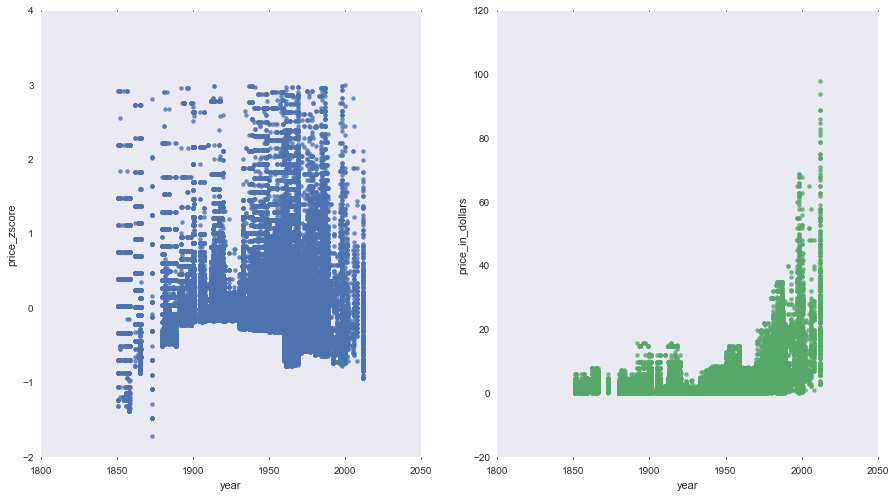

In [129]:

f, axes = plt.subplots(1,2, figsize = (15,8), sharex=False)
#Scatter plot of the zscore price of each dish per year
x= dish_outliers_removed['year']
y= dish_outliers_removed['price_zscore']
sns.regplot(x, y, fit_reg=False, ax = axes[0])

# This is the scatterplot we looked at earlier, now much better!
y= dish_outliers_removed['price_in_dollars']
sns.regplot(x, y, fit_reg=False, ax = axes[1])


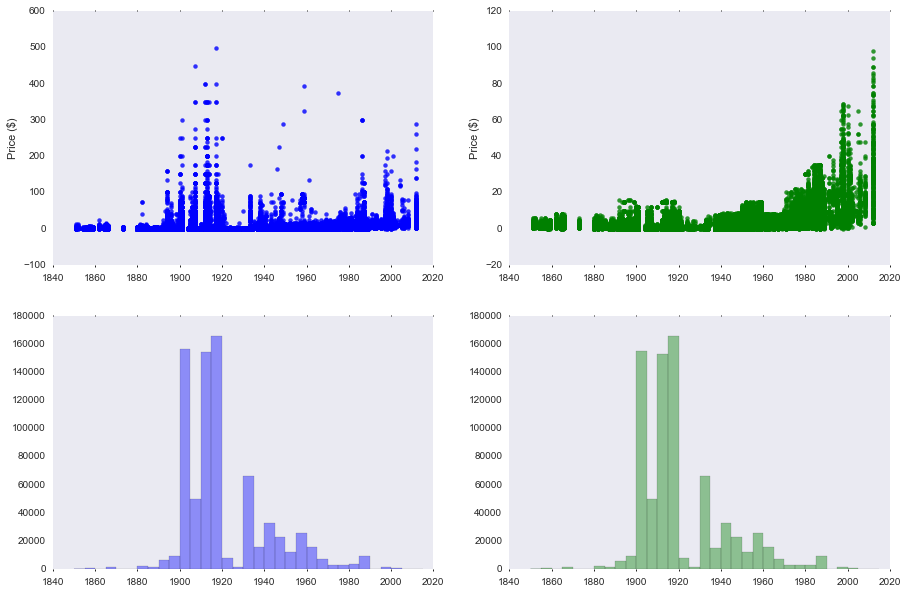

In [385]:
f, axes = plt.subplots(2,2, figsize = (15,10), sharex= False)

#Scatter plot of the price of each dish per year before cleaning
x= menu_dishes_df['year']
y= menu_dishes_df['price_in_dollars']
sns.regplot(x, y, fit_reg=False, color = 'blue', ax = axes[0,0]).set(xlim=(1840,2020), xlabel = '', ylabel = 'Price ($)')
ax.set_title('Distribution Before Cleaning', fontsize = 15) #fontsize=34,color="r",alpha=0.5)
# Histogram of the number of dishes per year before cleaning
sns.distplot(x, hist=True, kde= False, color = 'b', bins =range(1850,2020,5), axlabel= '', ax = axes[1,0])

#Scatter plot of the price of each dish per year after cleaning
x = dish_outliers_removed['year']
y= dish_outliers_removed['price_in_dollars']
sns.regplot(x, y, fit_reg=False, color = 'g', ax = axes[0,1]).set(xlim=(1840,2020), xlabel = '', ylabel = 'Price ($)')
ax.set_title('Distribution After Cleaning', fontsize = 15)
# Histogram of the number of dishes per year after cleaning
sns.distplot(x, hist=True, kde= False, color = 'g', bins =range(1850,2020,5), axlabel = '', ax = axes[1,1])

In [69]:
#dish_outliers_removed.groupby('name')['value'].nlargest(2)

775383

Let's look at the time period 1910-1940; what's different between pre-war and post-war?

In [349]:
wwar_df = dish_outliers_removed.loc[(dish_outliers_removed['year'] >= 1910) & (dish_outliers_removed['year'] <= 1940)]
# make a variable time_slice that is 'prewar', 'war', or 'postwar' 
wwar_df['time_frame'] = 0
prewar_mask = wwar_df['year'] <= 1914
war_mask = (wwar_df['year'] > 1914) & (wwar_df['year'] <= 1918)
post_war = wwar_df["year"] > 1918 # This is a larger time slice because the sample size drastically decreases after 1920

wwar_df['time_frame'].loc[prewar_mask] = 'Prewar'
wwar_df['time_frame'].loc[war_mask] = 'War'
wwar_df['time_frame'].loc[post_war] = 'Postwar'


# number of unique menu items by time_frame
wwar_df.groupby('time_frame')['name'].nunique()


/Users/amyshapiro/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/amyshapiro/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/amyshapiro/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/amyshapiro/anaconda2/li

time_frame
Postwar    31354
Prewar     44843
War        40733
Name: name, dtype: int64

In [350]:
pwar = wwar_df.loc[wwar_df['time_frame'] == 'Postwar']
count_pwar=pwar.groupby('dish_id').count()
count_pwar.describe()
pwar['name']

menu_item_id
568745                                         Chicken gumbo
566599                                                Caviar
568734                                       Consomme in cup
568740                                         Chicken broth
568700                                         Chicken salad
568773                                                Tongue
568824                                              Apricots
568768                                               Chicken
568807                                     Porterhouse Steak
568803                                      Tenderloin Steak
568820                                             Marmalade
568764                                              Cold Ham
568815                                                  Pies
568760                                         Smoked Tongue
568774                                                Cheese
568772                                                   Ham
568746     

In [351]:
count_of_dishes = wwar_df.groupby(['time_frame', 'name'])['name'].count()
count_of_dishes.sort_values(ascending = False).head(50)

time_frame  name                       
War         Celery                         540
Prewar      Celery                         514
            Apollinaris                    399
            Olives                         388
            Turkish Coffee                 321
            Plover                         321
            Crab Flake Cocktail            319
            Assorted Cakes                 318
            Green Peas                     318
            Cafe Parfait                   317
            Beluga Caviar                  317
War         Biscuit Tortoni                317
Postwar     Orange                         315
            Cocktail Sauce                 313
Prewar      Red Leg Partridge              313
Postwar     Lobster salad                  310
War         Radishes                       309
Postwar     Bread and Butter               306
Prewar      Ices in Souvenir               305
Postwar     Chicken salad                  300
Prewar      French C

This function takes in a data frame, column, and keyword and returns a new dataframe that contains only instances where the keyword is present (option to apply case or not). This can be used to quickly make new dataframes with only a specific dish, location, etc.

In [56]:
def check_name(df, column, word, case=False):
    newdf = df.loc[df[column].str.contains(word, case = case)]
    return newdf

Make some categories to look at

In [352]:
lobster_cocktail = check_name(wwar_df, 'name', 'lobster cocktail')
lobster_cocktail['dish_category'] = 'Lobster Cocktail'

celery = check_name(wwar_df, 'name', 'celery')
celery['dish_category'] = 'Raw '

lobster = check_name(wwar_df, 'name', 'lobster')
lobster['dish_category'] = 'Lobster'

chicken = check_name(wwar_df, 'name', 'chicken')
chicken['dish_category'] = 'Chicken'

oysters = check_name(wwar_df, 'name', 'oyster')
oysters['dish_category'] = 'Oysters'


lettuce_salad = check_name(wwar_df, 'name', 'lettuce salad')
lettuce_salad['dish_category'] = 'Lettuce Salad'

caviar = check_name(wwar_df, 'name', 'caviar')
caviar['dish_category'] = 'Caviar'

french_coffee = check_name(wwar_df, 'name', 'french coffee')
french_coffee['dish_category'] = 'French Coffee'

pheasant = check_name(wwar_df, 'name', 'english pheasant')
pheasant['dish_category'] = 'English Pheasant'

roquefort = check_name(wwar_df, 'name', 'roquefort')
roquefort['dish_category'] = 'Roquefort Cheese'

salad = check_name(wwar_df, 'name', 'salad')
salad['dish_category'] = 'Salad'

ham = check_name(wwar_df, 'name', 'ham')
ham['dish_category'] = 'Ham'

steak = check_name(wwar_df, 'name', 'steak')
steak['dish_category'] = 'Steak'

fg = check_name(wwar_df, 'name', 'Foie Gras')
fg['dish_category'] = 'Foie Gras'

coffee = check_name(wwar_df, 'name', 'Coffee')
coffee['dish_category'] = 'Coffee'


/Users/amyshapiro/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/amyshapiro/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/amyshapiro/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [361]:
ice_cream = check_name(wwar_df, 'name', 'ice cream')
ice_cream['dish_category'] = 'Ice Cream'
 
fried_potatoes = check_name(wwar_df, 'name', 'Fried Potatoes')
fried_potatoes['dish_category'] = 'Fried Potatoes'

potatoes = check_name(wwar_df, 'name', 'Potatoes')
potatoes['dish_category'] = 'Potatoes'

salad = check_name(wwar_df, 'name', 'salad')
salad['dish_category'] = 'Salad'

/Users/amyshapiro/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/amyshapiro/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/amyshapiro/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

Concat selected frames to graph

In [370]:
frames = [oysters, ham, potatoes, ice_cream, salad]
result = pd.concat(frames)

Group by time frame and dish category, and count the instances; reindex and make a new column to store the totals

In [373]:
number_plot = result.groupby(['time_frame', 'dish_category']).count()
number_plot = number_plot.reset_index('dish_category')
number_plot = number_plot[['dish_category', 'dish_id', 'name']]

#time_frame
postwar_num = 31354
prewar_num = 44843
war_num = 40733     

number_plot = number_plot.reset_index('time_frame')
number_plot = number_plot.rename(columns={"dish_id": "freq", "name": "norm_freq"})
number_plot['total'] = postwar_num


In [374]:
number_plot

,time_frame,dish_category,freq,norm_freq,total
0,Postwar,Ham,2589,2589,31354
1,Postwar,Ice Cream,2427,2427,31354
2,Postwar,Oysters,992,992,31354
3,Postwar,Potatoes,5908,5908,31354
4,Postwar,Salad,8923,8923,31354
5,Prewar,Ham,4789,4789,31354
6,Prewar,Ice Cream,2309,2309,31354
7,Prewar,Oysters,3024,3024,31354
8,Prewar,Potatoes,4972,4972,31354
9,Prewar,Salad,7710,7710,31354


Normalize by total dishes

In [375]:

number_plot['total'] = np.where(number_plot['time_frame'] == 'Prewar', prewar_num, number_plot['total'])
number_plot['total'] = np.where(number_plot['time_frame'] == 'War', war_num, number_plot['total'])
number_plot['norm_freq'] = number_plot['freq'] / number_plot['total']
number_plot

,time_frame,dish_category,freq,norm_freq,total
0,Postwar,Ham,2589,0.082573,31354
1,Postwar,Ice Cream,2427,0.077406,31354
2,Postwar,Oysters,992,0.031639,31354
3,Postwar,Potatoes,5908,0.188429,31354
4,Postwar,Salad,8923,0.284589,31354
5,Prewar,Ham,4789,0.106795,44843
6,Prewar,Ice Cream,2309,0.051491,44843
7,Prewar,Oysters,3024,0.067435,44843
8,Prewar,Potatoes,4972,0.110876,44843
9,Prewar,Salad,7710,0.171933,44843


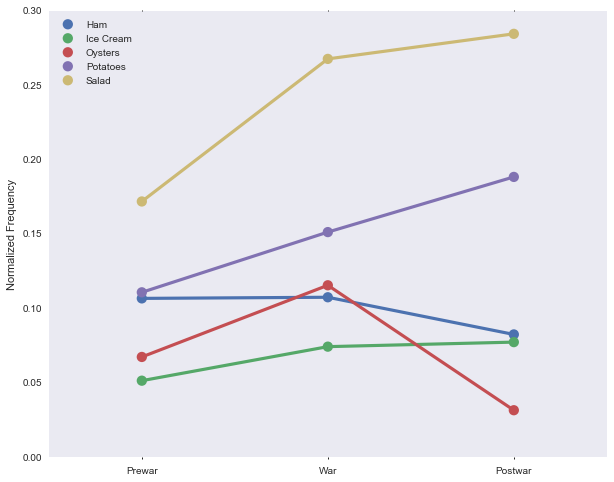

In [391]:
#Plot the number of selected dishes by time frame
x = number_plot['time_frame']
y = number_plot['norm_freq']

fig = sns.pointplot(x, y, hue = number_plot['dish_category'], order=["Prewar", "War", 'Postwar'])
fig.set(xlabel='', ylabel='Normalized Frequency')
fig.legend(title= '',loc='upper left')

### Here be Dragons! 

Things in progress

#### Looking at individual dishes

We might want to explore particular dishes, such as coffee.



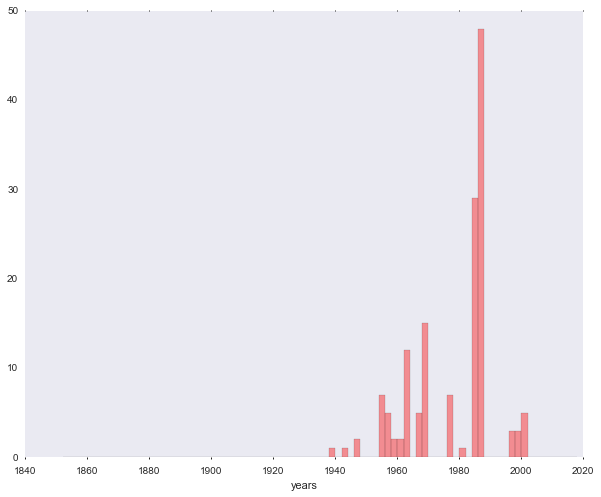

In [86]:

vich = check_name(dish_outliers_removed, 'name', 'Vichyssoise')
len(vich)

x = pizza_df['year']
sns.distplot(x, hist=True, kde= False, color = 'r', bins =range(1850,2020,2), axlabel= 'years')

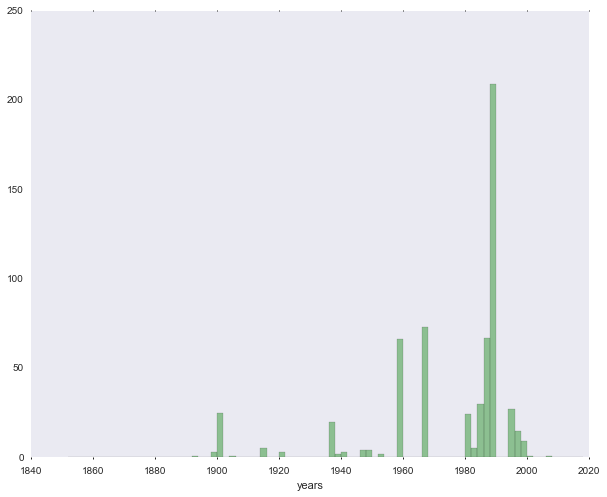

In [62]:
x = latin_df['year']
y = latin_df['price_in_dollars']

sns.distplot(x, hist=True, kde= False, color = 'g', bins =range(1850,2020,2), axlabel= 'years')

'Coffee' is the most common item on menus in the database (almost twice as common as anything else!). Let's see how that increases as we add other spellings and cases, add other languages' names such as 'espresso', and ignore punctuation. 

This makes a new dataframe with different types of coffee. This will also contain food items with coffee in their name, such as 'coffee ice icream'. 

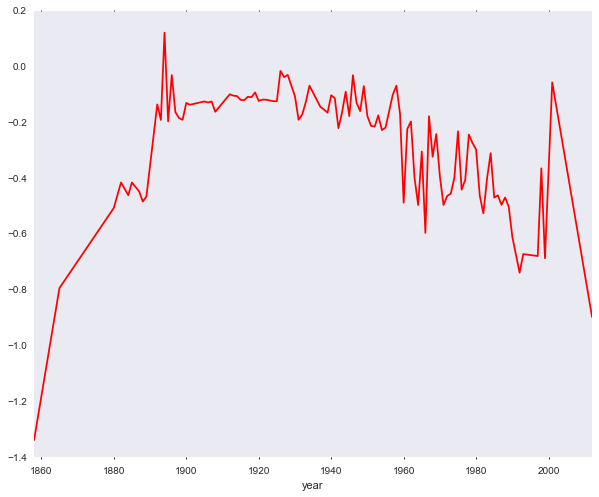

In [70]:
coffee_types= '|'.join(['cofee', 'coffe', 'cafe', 'caffe', 'kaffe', 'kafe', 'koffee',
                        'espresso', 'cappuccino', 'macchiato'])
coffee_dishes= check_name(dish_outliers_removed, 'name', coffee_types)

coffee_zscore_means=coffee_dishes['price_zscore'].groupby(coffee_dishes['year']).mean()
coffee_zscore_means.plot(kind='line', x='year', y='price_zscore', c='red')

This graph shows how coffee prices have decreased since 1940, but increased since 1990 (but there are also fewer datapoints.

### Text Processing

Can we cluster dishes based on the terms in their names?

The target is to make a dictionary with menu_item_id as the key and values  equal to all the words in the menu item name that are descriptive (ie no stopwords etc).


In [154]:
# First step: make a dict with menu_item_id as the key and values = name with 1)no punctuation 2) stop words removed
# 3) lower case

dishitemsDict = menu_dishes_df['name'].to_dict()

In [155]:
# Trying out another way of getting keywords 
#(from https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words):
import re

example1 = "Consomme printaniere roya'l."

letters_only = re.sub("[^a-zA-Z.' ]",           # The pattern to search for
                      "",                    # The pattern to replace it with
                      example1 )  # The text to search
#print letters_only

new_dishDict = {}

for k, v in dishitemsDict.iteritems():
    new_dishDict[k] = re.sub("[^a-zA-Z.' ]", "", v.lower()).split()

new_dishDict[1]

['consomme', 'printaniere', 'royal']

In [156]:
#Let's remove stopwords such as the, in, etc.
from nltk.corpus import stopwords
from sets import Set

#First make a set of stopwords; this will decrease the time it takes to search 
english = Set(stopwords.words('english'))
french = Set(stopwords.words('french'))
german = Set(stopwords.words('german'))
italian = Set(stopwords.words('italian'))
spanish = Set(stopwords.words('spanish'))

union_stopwords = english | french | german | italian | spanish

def dict_remove_stopwords(s):
    s_new = {}
    for k, v in s.iteritems():
        words = [w for w in v if not w in union_stopwords]
        s_new[k] = words
    return s_new

dishes_stopremDict = dict_remove_stopwords(new_dishDict)
    


In [157]:
dishes_stopremDict

{1: ['consomme', 'printaniere', 'royal'],
 2: ['chicken', 'gumbo'],
 3: ['tomato', 'croutons'],
 4: ['onion', 'gratin'],
 5: ['st.', 'emilion'],
 6: ['radishes'],
 8: ['clam', 'broth', 'cup'],
 9: ['cream', 'new', 'asparagus', 'croutons'],
 10: ['clear', 'green', 'turtle'],
 11: ['chicken', 'soup', 'rice'],
 12: ['striped', 'bass', 'saute', 'meuniere'],
 13: ['anchovies'],
 15: ['fresh', 'lobsters', 'every', 'style'],
 16: ['celery'],
 17: ['pimolas'],
 18: ['caviar'],
 19: ['sardines'],
 20: ['india', 'chutney'],
 21: ['pickles'],
 22: ['english', 'walnuts'],
 23: ['pate', 'foiesgras'],
 24: ['pomard'],
 25: ['brook', 'trout', 'mountain', 'style'],
 26: ['whitebait', 'sauce', 'tartare'],
 27: ['clams'],
 28: ['oysters'],
 30: ['g.', 'h.', 'mumm', "co's", 'extra', 'dry', 'qt.'],
 31: ['cerealine', 'milk'],
 33: ['radishes'],
 34: ['sliced', 'bananas'],
 35: ['wheat', 'vitos'],
 36: ['sliced', 'tomatoes'],
 37: ['russian', 'caviare', 'toast'],
 38: ['smoked', 'beef', 'cream'],
 39: ['oa

In [158]:
# Now that we have keywords, we can try some clustering techniques! First let's try tokenizing each entry. Actually
# looks like one can tokenize a sentence and this might be better than the above strip etc

def dict_tokenize(s):
#Takes a dictionary of strings and returns the dictionary with the tagged tokenized strings 
    import nltk
    new_s = {}
    for k, v in s.iteritems():
        tokens = nltk.word_tokenize(v)
        new_s[k] =  nltk.pos_tag(tokens)
    return new_s

testDict = {1:'aux pommes', 2:'peas in sauce', 3:'Fuchs, rot'}

dict_tokenize(testDict)

{1: [('aux', 'NN'), ('pommes', 'NNS')],
 2: [('peas', 'NNS'), ('in', 'IN'), ('sauce', 'NN')],
 3: [('Fuchs', 'NNP'), (',', ','), ('rot', 'NN')]}

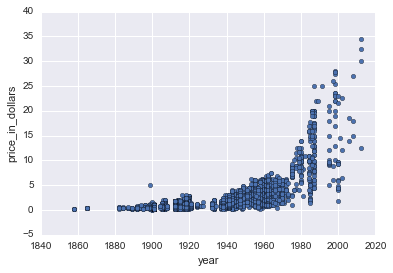

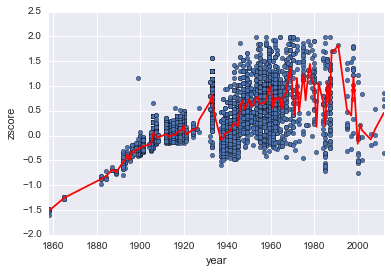

In [102]:
# Everyone loves lobster! ><<<3   
#Make a df lobster_dishes which are all dishes that contain the word 'lobster'; let's also see how prices for lobster
# dishes have changed over time; 
lobster_dishes = check_name(price_per_dish_standardized, 'name', 'lobster')
lobster_dishes.describe()
lobster_dishes.plot.scatter('year', 'price_in_dollars')
lobster_dishes.plot.scatter('year', 'zscore')
lobster_zscore_means=lobster_dishes['zscore'].groupby(lobster_dishes['year']).mean()
lobster_zscore_means.plot(kind='line', x='year', y='zscore', c= 'red')


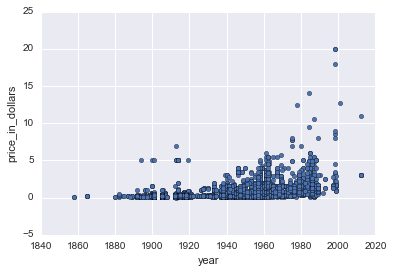

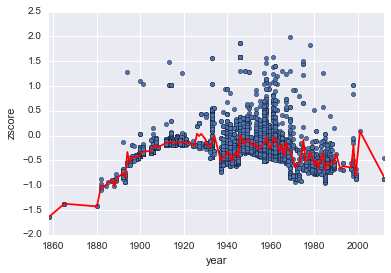

In [110]:
# Also, everyone loves coffee! 'Coffee' is the most common item on menus in the database. Let's make a df of dishes 
# that contain the word 'coffee' or its various other spellings, as well as the Italian names espresso, cappuccino, or
# macchiato (latte is too common?) This will also contain non-coffee food items, for example Coffee ice cream. 
#Actually, let's remove all dishes that have 'ice cream' in them 
coffee_types= '|'.join(['cofe', 'coffe', 'cafe', 'caffe', 'kaffe', 'kafe', 'koffee',\
                        'espresso', 'cappuccino', 'macchiato'])
coffee_dishes= check_name(price_per_dish_standardized, 'name', coffee_types)
coffee_dishes_noi = coffee_dishes[~coffee_dishes['name'].str.contains("ice cream")]
coffee_dishes_noi.head()

coffee_dishes.plot.scatter('year', 'price_in_dollars')
coffee_dishes.plot.scatter('year', 'zscore')
coffee_zscore_means=coffee_dishes['zscore'].groupby(coffee_dishes['year']).mean()
coffee_zscore_means.plot(kind='line', x='year', y='zscore', c='red')
